In [1]:
#from gurobipy import*
import pandas as pd
import geopandas as gpd
import numpy as np
#import googlemaps
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox

In [2]:
from pyproj import CRS, Transformer
projection=CRS.from_epsg(2263)

In [3]:
place_name='Manhattan, New York, USA'
graph = ox.graph_from_place(place_name,network_type='drive')


In [4]:
#leisure = ox.footprints_from_place(place_name,footprint_type='leisure')

<AxesSubplot:>

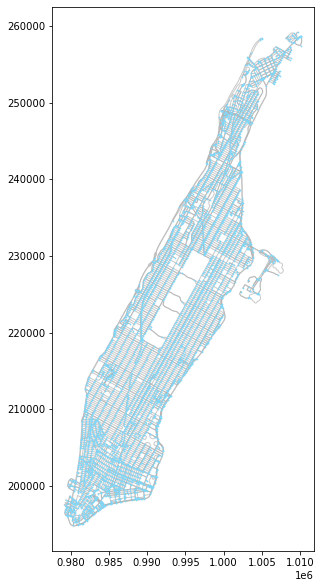

In [5]:
#ox.plot_graph(graph)
#area = ox.gdf_from_place(place_name)
#type(area)
#area.plot()
nodes,edges = ox.graph_to_gdfs(graph)
edges=edges.to_crs(projection)
nodes=nodes.to_crs(projection)
#area=area.to_crs(projection)
#fig2, ax2 = ox.plot_graph(graph)
fig,ax=plt.subplots(figsize=(18,10))
nodes.plot(ax=ax,color='#7DD9FC',markersize=0.5, zorder=10)
#area.plot(ax=ax, alpha=0.5, zorder=0)
edges.plot(ax=ax,linewidth=1,color='#B4B3B3',alpha=0.7, zorder=5)


In [6]:
requests=pd.DataFrame(columns=['id','o_lat','o_lon','d_lat','d_lon','t_r'])
vehicles=pd.DataFrame(columns=['id','v_lat','v_lon','pas'])
trips=pd.DataFrame(columns=['v_id','r_id'])

In [7]:
edges.columns
edges.crs
edges['highway'].value_counts()
graph_proj = ox.project_graph(graph,to_crs=CRS.from_epsg(2263))
nodes_proj,edges_proj = ox.graph_to_gdfs(graph_proj)

In [8]:
CRS(nodes_proj.crs).to_epsg()
stats = ox.basic_stats(graph_proj,circuity_dist='euclidean')
convex = edges_proj.unary_union.convex_hull
centroid = convex.centroid
node_maxx = nodes_proj.loc[nodes_proj['x']==nodes_proj['x'].max(),'geometry'].values[0]

start_node = ox.get_nearest_node(graph_proj,(centroid.y,centroid.x),method='euclidean')
end_node = ox.get_nearest_node(graph_proj,(node_maxx.y,node_maxx.x),method='euclidean')
path = nx.shortest_path(graph_proj,source=start_node,target=end_node, weight='length')

In [9]:
start_node_pt = nodes_proj.loc[start_node]
end_node_pt = nodes_proj.loc[end_node]
new_gdf = gpd.GeoDataFrame([start_node_pt,end_node_pt], geometry='geometry',crs=edges_proj.crs)
route_nodes = nodes_proj.loc[path]
from shapely.geometry import LineString, Point, MultiLineString
test = list(route_nodes.geometry.values)
route_line = LineString(test)
#print(route_line)
route_line_geom = gpd.GeoDataFrame([route_line], geometry='geometry',columns=['geometry'])
route_line_geom

,geometry
0,"LINESTRING (995980.942 225402.308, 996425.533 ..."


<AxesSubplot:>

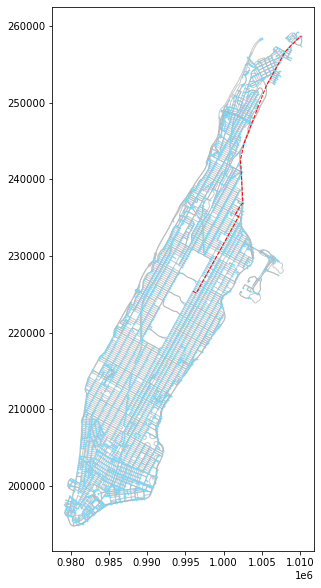

In [10]:
fig,ax=plt.subplots(figsize=(18,10))
nodes_proj.plot(ax=ax,color='#7DD9FC',markersize=0.5, zorder=10)
edges_proj.plot(ax=ax,linewidth=1,color='#B4B3B3',alpha=0.7, zorder=5)
route_line_geom.plot(ax=ax,color='red',zorder=15,linewidth=1, linestyle='--')

In [11]:
#def travel_time(o_lat,o_lon,d_lat,d_lon):
#shortest travel time between two locations

In [12]:
for col in ['lanes', 'maxspeed', 'name', 'oneway', 'osmid','bridge','access','ref','tunnel','width','junction','service','u','v','key']:
    edges_proj[col]=edges_proj[col].astype(str)
import os
edges_proj
#edges_proj.to_csv('streets_man1.csv')
#nodes_proj.to_csv('nodes_man1')

In [13]:
#nodes_proj.to_csv('nodes_man1')

test_1=pd.DataFrame()
for o in nodes_proj.index:
    for d in nodes_proj.index:
        test_1.loc[o,d]=0

In [14]:
edges_proj['highway'].value_counts()

residential                     3758
secondary                       2899
primary                         1866
tertiary                         588
motorway_link                    250
unclassified                     173
motorway                         140
trunk                            125
secondary_link                    37
primary_link                      36
trunk_link                        18
tertiary_link                      9
[residential, unclassified]        5
living_street                      5
[motorway_link, motorway]          1
[primary, motorway]                1
[trunk, motorway]                  1
[tertiary, secondary_link]         1
[tertiary, motorway_link]          1
[unclassified, residential]        1
[primary_link, primary]            1
[residential, primary_link]        1
[residential, motorway_link]       1
[primary, motorway_link]           1
[primary, secondary_link]          1
[secondary, motorway_link]         1
Name: highway, dtype: int64

In [17]:
request=pd.read_csv('test_requests.csv',header=0)

In [18]:
transformer = Transformer.from_crs("epsg:4326", "epsg:2263")

In [19]:
request_proj=pd.DataFrame()
for index,row in request.iterrows():
    request_proj.loc[index,'o_x'],request_proj.loc[index,'o_y']=transformer.transform(row['o_lat'],row['o_lon'])
    request_proj.loc[index,'d_x'],request_proj.loc[index,'d_y']=transformer.transform(row['d_lat'],row['d_lon'])
request_geom=[]
#request_geom_pts=gpd.GeoDataFrame(geometry='geometry',columns=['u','v','geometry'])
for o_x,o_y,d_x,d_y in request_proj.itertuples(index=False):
    request_geom.append(LineString([[o_x,o_y],[d_x,d_y]]))
    #{'u':node1,'v':node2,'geometry':Point([o_x,o_y])},ignore_index=True
request_geom_df=gpd.GeoDataFrame(request_proj, geometry=request_geom)

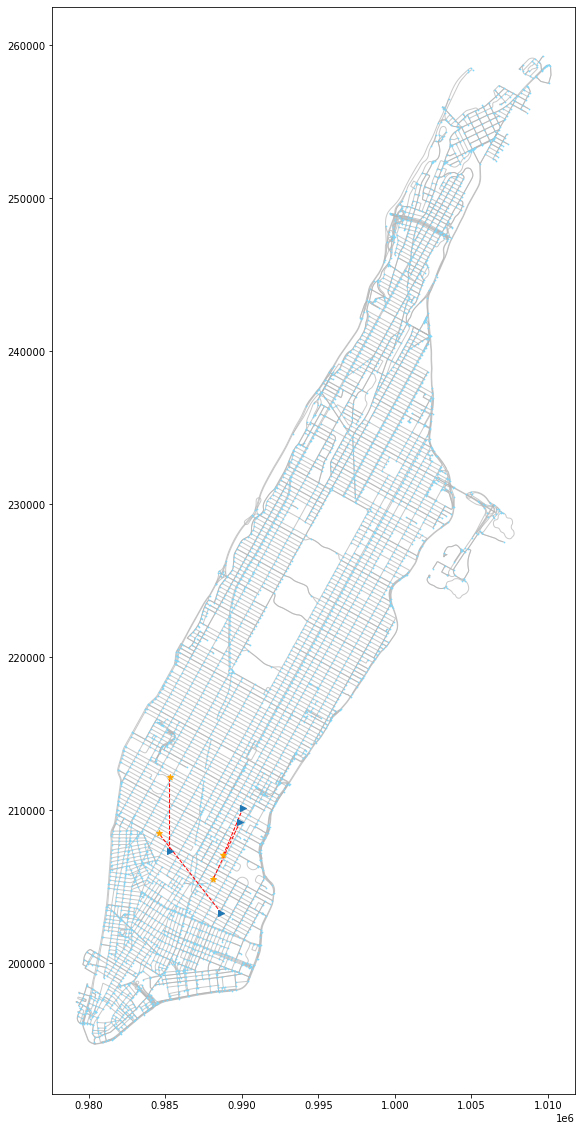

In [20]:
fig,ax=plt.subplots(figsize=(30,20))
nodes_proj.plot(ax=ax,color='#7DD9FC',markersize=0.5, zorder=10)
edges_proj.plot(ax=ax,linewidth=1,color='#B4B3B3',alpha=0.7, zorder=5)
request_geom_df.plot(ax=ax,linewidth=1,color='red',linestyle='--',zorder=10,label=request_geom_df.index)
ax.scatter(request_proj['o_x'],request_proj['o_y'],marker=">",zorder=15)
ax.scatter(request_proj['d_x'],request_proj['d_y'],marker="*",color="orange",zorder=15)

In [21]:
request_geom_df
route_line_request=[]
nodes_pair=[]
nodes_dist=[]
for o_x,o_y,d_x,d_y,geom in request_proj.itertuples(index=False):
    o_node = ox.get_nearest_node(graph_proj,(o_y,o_x),method='euclidean')
    d_node = ox.get_nearest_node(graph_proj,(d_y,d_x),method='euclidean')
    path_request = nx.shortest_path(graph_proj,source=o_node,target=d_node, weight='length')
    route_nodes_request = nodes_proj.loc[path_request]
    route_nodes_request_list = list(route_nodes_request.geometry.values)
    route_line_request.append(LineString(route_nodes_request_list))
    nodes_pair.append([o_node,d_node])
    nodes_dist.append(o_node)
    nodes_dist.append(d_node)
route_line_geom_request = gpd.GeoDataFrame(geometry= route_line_request,columns=['geometry'])

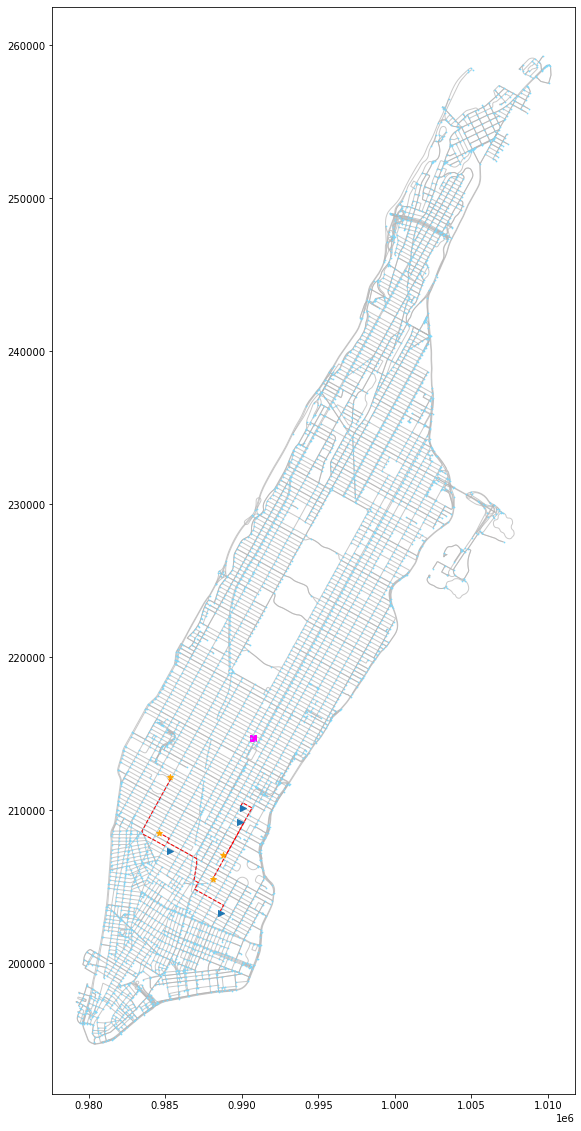

In [22]:
nodes_dist_v=[]
v_x,v_y=transformer.transform(40.75611, -73.97665)
v_node = ox.get_nearest_node(graph_proj,(v_y,v_x),method='euclidean')
nodes_dist_v.append(v_node)
for aa in nodes_dist:
    nodes_dist_v.append(aa)
fig,ax=plt.subplots(figsize=(30,20))
nodes_proj.plot(ax=ax,color='#7DD9FC',markersize=0.5, zorder=10)
edges_proj.plot(ax=ax,linewidth=1,color='#B4B3B3',alpha=0.7, zorder=5)
route_line_geom_request.plot(ax=ax,linewidth=1,color='red', zorder=10, linestyle='--')
#request_geom_df.plot(ax=ax,linewidth=1,color='red',linestyle='--',zorder=10,label=request_geom_df.index)
ax.scatter(request_proj['o_x'],request_proj['o_y'],marker=">",zorder=15)
ax.scatter(request_proj['d_x'],request_proj['d_y'],marker="*",color="orange",zorder=15)
ax.scatter(v_x,v_y,marker="s",color="magenta",zorder=9)
#for x,y,i in zip(nodes_proj.loc[nodes_dist_v].x,nodes_proj.loc[nodes_dist_v].y,nodes_proj.loc[nodes_dist_v].index):
 #   ax.annotate(nodes_dist_v.index(i), (x, y),zorder=10,fontsize=12)

In [23]:
dist_all_nodes=gpd.GeoDataFrame(geometry='geometry',columns=['u','v','geometry','length'])
i=0
j=0

for node1 in nodes_dist_v:
    row1=[]
    for node2 in nodes_dist_v:
        if node1==node2:
            pass
            j=j+1
        else:
            path_node_pair = nx.shortest_path(graph_proj,source=node1,target=node2, weight='length')
            route_node_pair = nodes_proj.loc[path_node_pair]
            route_nodes_pair_list = list(route_node_pair.geometry.values)
            dist_all_nodes=dist_all_nodes.append({'u':node1,'v':node2,'geometry':LineString(route_nodes_pair_list),'length':LineString(route_nodes_pair_list).length},ignore_index=True)
            j=j+1
    i=i+1

In [24]:
#create request pairs with nex index
nex_index_pair = []
for row_list in nodes_pair:
    row_add=[]
    for num_row in row_list: 
        for check_val in nodes_dist_v:
            if num_row == check_val: 
                row_add.append(nodes_dist_v.index(check_val))
    nex_index_pair.append(row_add)

In [25]:
#create distance matrix with nex index
data_dist=[]
a=0
b=0
for o in nodes_dist_v:
    row=[]
    for d in nodes_dist_v:
        if o==d:
            row.append(0)
            b=b+1
            pass
        else:
            row.append(dist_all_nodes.loc[(dist_all_nodes['u']==o)&(dist_all_nodes['v']==d),'length'].values[0])
            b=b+1
    data_dist.append(row)
    a=a+1      
pd.DataFrame(data_dist).round(1)

,0,1,2,3,4,5,6,7,8
0,0.0,6786.7,10316.9,7742.0,11910.7,14957.6,10739.4,10418.5,8051.5
1,5741.2,0.0,4571.5,1996.6,6165.4,9374.0,8058.2,7658.0,5374.3
2,10284.2,4544.5,0.0,4470.9,1593.9,4802.5,5423.3,5017.4,8882.0
3,7729.5,1988.3,2574.9,0.0,4168.7,7377.4,7984.6,7582.3,6329.6
4,11542.6,6182.5,3545.2,6108.9,0.0,3208.6,5766.9,4416.5,10140.4
5,14062.7,8857.1,5296.9,7901.4,3745.6,0.0,8286.9,6936.6,12493.9
6,11307.0,8626.0,5997.0,8553.8,5357.7,8227.3,0.0,1997.2,4472.7
7,10408.2,7727.2,5098.2,7655.1,4458.9,7516.0,1475.4,0.0,5873.8
8,8051.2,5377.6,8136.5,6169.7,9673.3,12730.4,5001.5,6998.7,0.0


In [26]:
from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [27]:
def create_data_model(distance_matrix,requests,veh):
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = distance_matrix
    data['pickups_deliveries'] = requests
    data['num_vehicles'] = veh
    data['depot'] = 0
    return data

In [28]:
# Instantiate the data problem.
data = create_data_model(data_dist,nex_index_pair,1)

In [29]:
# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),data['num_vehicles'], data['depot'])

In [30]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    total_distance = 0
    node_all=[]
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            node_all.append(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        node_all.append(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        total_distance += route_distance
    print('Total Distance of all routes: {}m'.format(total_distance))
    return(node_all)

In [31]:
# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

In [32]:
# Define cost of each arc.
def distance_callback(from_index, to_index):
    """Returns the manhattan distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

In [33]:
# Add Distance constraint.
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    300000,  # vehicle maximum travel distance
    True,  # start cumul to zero
    dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

In [34]:
# Define Transportation Requests.
for request in data['pickups_deliveries']:
    pickup_index = manager.NodeToIndex(request[0])
    delivery_index = manager.NodeToIndex(request[1])
    routing.AddPickupAndDelivery(pickup_index, delivery_index)
    routing.solver().Add(
        routing.VehicleVar(pickup_index) == routing.VehicleVar(
            delivery_index))
    routing.solver().Add(
        distance_dimension.CumulVar(pickup_index) <=
        distance_dimension.CumulVar(delivery_index))

In [35]:
# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PARALLEL_CHEAPEST_INSERTION)

In [36]:
# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

In [37]:
# Print solution on console.
result = print_solution(data, manager, routing, solution)

Route for vehicle 0:
 0 ->  1 ->  3 ->  2 ->  4 ->  5 ->  7 ->  6 ->  8 -> 0
Distance of the route: 37091m

Total Distance of all routes: 37091m


In [38]:
result_list=list( nodes_dist_v[i] for i in result)
result_geom = gpd.GeoDataFrame(geometry='geometry', columns=['u','v','geometry','length'])
for i in range(len(result_list)-1):
    result_geom = result_geom.append(dist_all_nodes.loc[(dist_all_nodes['u']== result_list[i]) & (dist_all_nodes['v']== result_list[i+1])])

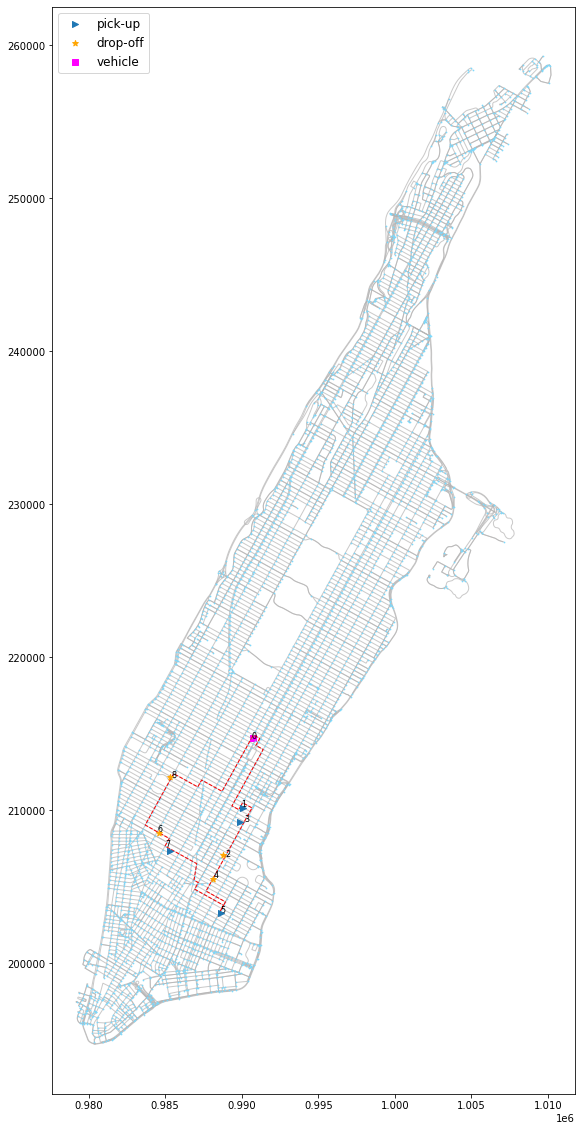

In [39]:
fig,ax=plt.subplots(figsize=(30,20))
nodes_proj.plot(ax=ax,color='#7DD9FC',markersize=0.5, zorder=10)
edges_proj.plot(ax=ax,linewidth=1,color='#B4B3B3',alpha=0.7, zorder=5)
#route_line_geom_request.plot(ax=ax,linewidth=1,color='red', zorder=10, linestyle='--')
#request_geom_df.plot(ax=ax,linewidth=1,color='red',linestyle='--',zorder=10,label=request_geom_df.index)
result_geom.plot(ax=ax,linewidth=1,color='red',linestyle='--',zorder=10)
ax.scatter(request_proj['o_x'],request_proj['o_y'],marker=">",zorder=15,label='pick-up')
ax.scatter(request_proj['d_x'],request_proj['d_y'],marker="*",color="orange",zorder=15,label='drop-off')
ax.scatter(v_x,v_y,marker="s",color="magenta",zorder=9,label='vehicle')
for x,y,i in zip(nodes_proj.loc[nodes_dist_v].x,nodes_proj.loc[nodes_dist_v].y,nodes_proj.loc[nodes_dist_v].index):
    ax.annotate(nodes_dist_v.index(i), (x, y),zorder=10,fontsize=8)
ax.legend(fontsize="large")
plt.savefig('ex_darp.png')